In [ ]:
%pip install numpy
%pip install matplotlib

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Carregar os dados

In [25]:
data = np.loadtxt(r'assets\spiral.csv', delimiter=',')
X = np.array(data[:, :2].T)
Y = np.array(data[:, 2].T).astype(int)

Preparação dos dados

In [26]:
p, N = X.shape
X = np.concatenate((-np.ones((1, N)), X))  # Bias
Y[Y == 0] = -1  # Ajustando as classes para [-1, 1]

Funções auxiliares

In [27]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    return sigmoid(z) * (1 - sigmoid(z))

def sinal(u_t):
    return np.where(u_t >= 0, 1, -1)

Parâmetros do MLP

In [35]:
n_hidden = 10
rodadas = 500
aprendizado = 0.01
epocas = 1000

Métricas

In [29]:
acuracias = []
sensibilidades = []
especificidades = []
matrizes_de_confusao = []

Rodadas de Monte Carlo

In [30]:
for i in range(rodadas):
    print(f"Rodada {i + 1}/{rodadas}", end='\r')

    # Inicialização dos pesos
    W1 = np.random.randn(n_hidden, p + 1)  # Entrada -> 1ª camada
    W2 = np.random.randn(n_hidden, n_hidden + 1)  # 1ª camada -> 2ª camada
    W3 = np.random.randn(1, n_hidden + 1)  # 2ª camada -> saída

    # Separação em treino e teste
    seed = np.random.permutation(N)
    Xr, yr = X[:, seed], Y[seed]
    treino_size = int(N * 0.8)
    X_treino, y_treino = Xr[:, :treino_size], yr[:treino_size]
    X_teste, y_teste = Xr[:, treino_size:], yr[treino_size:]

    # Treinamento do MLP
    for _ in range(epocas):
        # Forward pass
        Z1 = W1 @ X_treino
        A1 = np.vstack((-np.ones((1, treino_size)), sigmoid(Z1)))
        Z2 = W2 @ A1
        A2 = np.vstack((-np.ones((1, treino_size)), sigmoid(Z2)))
        Z3 = W3 @ A2
        A3 = sigmoid(Z3)

        # Backpropagation
        erro_saida = y_treino - A3.flatten()
        delta3 = (erro_saida * A3.flatten() * (1 - A3.flatten())).reshape(1, -1)  # Ensure delta3 is 2D
        grad_W3 = delta3 @ A2.T

        delta2 = (W3[:, 1:].T @ delta3) * A2[1:] * (1 - A2[1:])
        grad_W2 = delta2 @ A1.T

        delta1 = (W2[:, 1:].T @ delta2) * A1[1:] * (1 - A1[1:])
        grad_W1 = delta1 @ X_treino.T


        # Atualização dos pesos
        W3 += aprendizado * grad_W3
        W2 += aprendizado * grad_W2
        W1 += aprendizado * grad_W1

    # Teste do MLP
    Z1 = W1 @ X_teste
    A1 = np.vstack((-np.ones((1, X_teste.shape[1])), sigmoid(Z1)))
    Z2 = W2 @ A1
    A2 = np.vstack((-np.ones((1, X_teste.shape[1])), sigmoid(Z2)))
    Z3 = W3 @ A2
    Y_predito = sinal(Z3).flatten()

    # Métricas
    TP = np.sum((Y_predito == 1) & (y_teste == 1))
    TN = np.sum((Y_predito == -1) & (y_teste == -1))
    FP = np.sum((Y_predito == 1) & (y_teste == -1))
    FN = np.sum((Y_predito == -1) & (y_teste == 1))

    acuracias.append((TP + TN) / len(y_teste))
    sensibilidades.append(TP / (TP + FN) if (TP + FN) > 0 else 0)
    especificidades.append(TN / (TN + FP) if (TN + FP) > 0 else 0)
    matrizes_de_confusao.append([[TP, FP], [FN, TN]])


#### Resultados

In [31]:
rodada_max_acuracia = np.argmax(acuracias)
rodada_min_acuracia = np.argmin(acuracias)

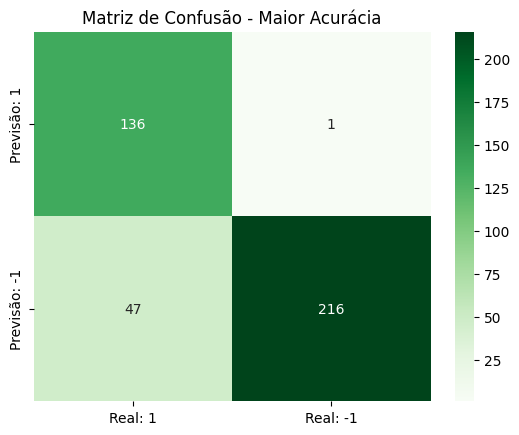

In [32]:
sns.heatmap(matrizes_de_confusao[rodada_max_acuracia], annot=True, fmt='d', cmap='Greens',
            xticklabels=['Real: 1', 'Real: -1'], yticklabels=['Previsão: 1', 'Previsão: -1'])
plt.title('Matriz de Confusão - Maior Acurácia')
plt.show()

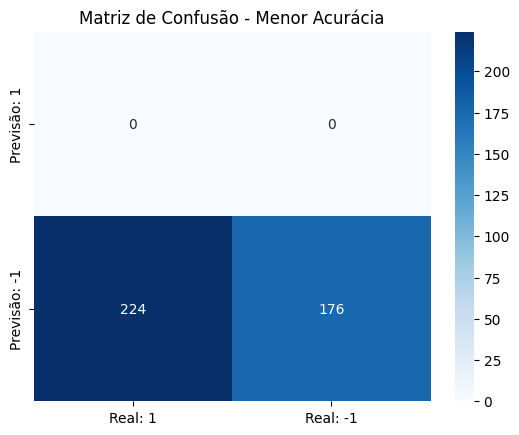

In [33]:
sns.heatmap(matrizes_de_confusao[rodada_min_acuracia], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real: 1', 'Real: -1'], yticklabels=['Previsão: 1', 'Previsão: -1'])
plt.title('Matriz de Confusão - Menor Acurácia')
plt.show()

In [34]:
print(
f'''Acurácia: 
    Média={np.mean(acuracias):.4f} 
    DP={np.std(acuracias):.4f} 
    Max={np.max(acuracias):.4f} 
    Min={np.min(acuracias):.4f}''', end='\n\n')
print(
f'''Sensibilidade: 
    Média={np.mean(sensibilidades):.4f} 
    DP={np.std(sensibilidades):.4f} 
    Max={np.max(sensibilidades):.4f} 
    Min={np.min(sensibilidades):.4f}''', end='\n\n')
print(
f'''Especificidade: 
    Média={np.mean(especificidades):.4f} 
    DP={np.std(especificidades):.4f} 
    Max={np.max(especificidades):.4f} 
    Min={np.min(especificidades):.4f}''', end='\n\n')

Acurácia: 
    Média=0.6949 
    DP=0.0800 
    Max=0.8800 
    Min=0.4400

Sensibilidade: 
    Média=0.4223 
    DP=0.1764 
    Max=0.7525 
    Min=0.0000

Especificidade: 
    Média=0.9681 
    DP=0.0498 
    Max=1.0000 
    Min=0.7095

